In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../..'))
import examples.linguistic_case_study as lng

from g4l.estimators import BIC
from g4l.estimators import SMC
import g4l.display
from g4l.estimators import Prune
from g4l.models import ContextTree
from g4l.data import Sample
from g4l.bootstrap.resampling import BlockResampling
from g4l.bootstrap import Bootstrap
pd.set_option('display.max_colwidth', None)


#results_folder = os.path.abspath('../simulation_study/results')
max_depth = 4
num_resamples = 200
num_cores = 6
penalty_interval = (0.1, 400)
epsilon = 0.01
renewal_point = '4'
samples_folder = "../../examples/linguistic_case_study"

In [4]:
# Set folders for temporary files
cache_folder = "../../examples/linguistic_case_study/cache/smc_matlab_compat2"
resamples_folder = '%s/resamples' % cache_folder
resamples_file = "%s/resamples.txt" % resamples_folder

In [5]:
# Load samples
X_bp = Sample('%s/folha.txt.bkp' % samples_folder, [0, 1, 2, 3, 4], subsamples_separator='>')
X_ep = Sample('%s/publico.txt.bkp' % samples_folder, [0, 1, 2, 3, 4], subsamples_separator='>')


In [6]:
def model_df(champion_trees, opt_idx):
    df = pd.DataFrame(columns=['idx', 'num_contexts', 'log_likelihood', 'tree', 'opt'])
    df['opt'] = 0
    for i, tree in enumerate(champion_trees):
        opt = i == opt_idx
        df.loc[len(df)] = [i, tree.num_contexts(), tree.log_likelihood(), tree.to_str(reverse=True), opt]
    opt_tree = champion_trees_bp[opt_idx]
    return df.sort_values('idx', ascending=False)

### Estimating models for Brazilian Portuguese (BP) 

In [7]:
champion_trees_bp, opt_idx_bp, smc_bp = lng.run_smc(X_bp, cache_folder, instance_name='bp', num_cores=4)
opt_tree_bp = champion_trees_bp[opt_idx_bp]
df_bp = model_df(champion_trees_bp, opt_idx_bp)
print("Total champion trees: ", len(champion_trees_bp))
print("Selected tree BP:", champion_trees_bp[opt_idx_bp].to_str(reverse=True))
df_bp.head(8)[['num_contexts', 'tree']]

Loaded from cache
Total champion trees:  19
Selected tree BP: 0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 2 03 13 33 43 4


,num_contexts,tree
18,1,
17,9,00 10 20 30 1 2 3 4
16,12,000 100 200 300 10 20 30 1 2 3 4
15,14,000 100 200 300 10 20 30 001 201 21 2 3 4
14,15,000 100 200 300 010 210 20 30 001 201 21 2 3 4
13,16,000 100 200 300 0010 2010 210 20 30 001 201 21 2 3 4
12,17,0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 2 3 4
11,20,0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 2 03 13 33 43 4


### Estimating models for European Portuguese (EP) 

In [8]:
champion_trees_ep, opt_idx_ep, smc_ep = lng.run_smc(X_ep, cache_folder, instance_name='ep', num_cores=4)
opt_tree_ep = champion_trees_ep[opt_idx_ep]
df_ep = model_df(champion_trees_ep, opt_idx_ep)
print("Total champion trees: ", len(champion_trees_ep))
print("Selected tree EP:", opt_tree_ep.to_str(reverse=True))
df_ep.head(8)[['num_contexts', 'tree']]

Loaded from cache
Total champion trees:  20
Selected tree EP: 000 100 200 300 010 210 20 30 001 201 21 02 12 32 42 3 4


,num_contexts,tree
19,1,
18,8,00 10 20 30 1 2 3 4
17,11,000 100 200 300 10 20 30 1 2 3 4
16,13,000 100 200 300 10 20 30 001 201 21 2 3 4
15,14,000 100 200 300 010 210 20 30 001 201 21 2 3 4
14,17,000 100 200 300 010 210 20 30 001 201 21 02 12 32 42 3 4
13,20,000 100 200 300 010 0210 1210 3210 4210 20 30 001 201 21 02 12 32 42 3 4
12,21,000 100 200 300 0010 2010 0210 1210 3210 4210 20 30 001 201 21 02 12 32 42 3 4


BP


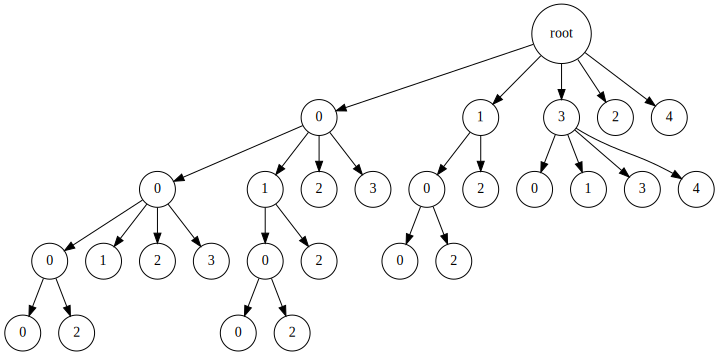

In [9]:
import g4l.display
print("BP")
g4l.display.draw_tree(opt_tree_bp, size='100,300')

BP


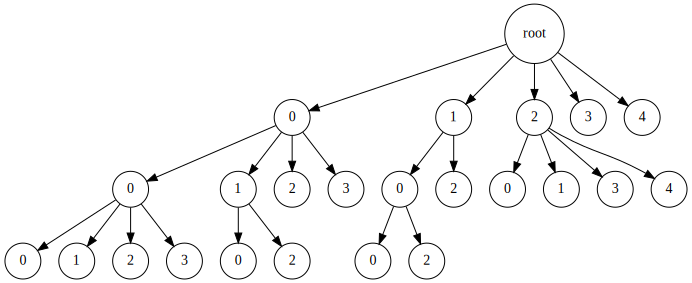

In [10]:
print("BP")
g4l.display.draw_tree(opt_tree_ep, size='100,300')

In [9]:
print('BP:', opt_tree_bp.to_str(reverse=True))
print('EP:', opt_tree_ep.to_str(reverse=True))

BP: 0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 2 3 4
EP: 000 100 200 300 010 210 20 30 001 201 21 02 12 32 42 3 4


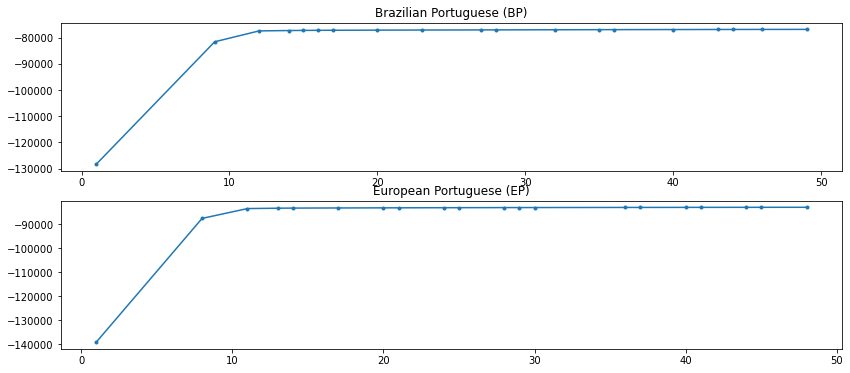

In [11]:
plt.figure(figsize=(14, 6))
txt = ['Brazilian Portuguese (BP)', 'European Portuguese (EP)']
for i, el in enumerate([champion_trees_bp, champion_trees_ep]):
    plt.subplot(2, 1, i+1)
    num_contexts = [t.num_contexts() for t in el]
    likelihoods = [t.log_likelihood() for t in el]
    plt.plot(num_contexts, likelihoods, marker='.')
    plt.title(txt[i])
plt.show()

In [15]:
def transition_table_df(tree):
    dd = tree.transition_probs.set_index('idx')
    df2 = pd.DataFrame(columns=['w', 'nodesort', 'p(0|w)', 'p(1|w)', 'p(2|w)', 'p(3|w)'])
    for i, row in tree.tree().iterrows():
        ps = [dd[dd.next_symbol == j].loc[row.node_idx].prob.round(2) for j in [0, 1, 2, 3]]
        df2.loc[len(df2)] = [row.node, row.node[::-1], *ps]
    df2.sort_values('nodesort', inplace=True)
    df2.set_index('nodesort', inplace=True)
    df2.reset_index(inplace=True, drop=True)
    return df2

transition_table_df(opt_tree_bp)


KeyError: "None of ['idx'] are in the columns"

In [12]:
transition_table_df(opt_tree_ep)

,w,p(0|w),p(1|w),p(2|w),p(3|w)
0,000,0.27,0.73,0.00,0.00
1,100,0.00,0.00,0.67,0.25
2,200,0.36,0.64,0.00,0.00
3,300,0.00,0.00,0.70,0.20
4,010,0.05,0.00,0.67,0.19
5,210,0.08,0.00,0.63,0.21
6,20,0.45,0.55,0.00,0.00
7,30,0.05,0.00,0.63,0.27
8,001,0.61,0.00,0.28,0.07
9,201,0.72,0.00,0.19,0.07


In [14]:
import g4l.display as dsp
dsp.toytree(opt_tree_ep, layout='l', height=500)

KeyError: ''

In [16]:
dsp.toytree(opt_tree_bp, layout='l', height=500)

KeyError: ''